# Unstructured grid and general mesh generation with FloPy

In this notebook we'll cover how to build Structured and Unstructured Meshes (Grids) with FloPy for use in MODFLOW models. 

This notebook will start with generating a simple Structured Grid and we will use this grid object to begin developing Unstructured Meshes. The grids generated in theis notebook include the following:

   - Regular structured grid (review)
   - Irregular structured grid with variable row and column spacings
   - Local Grid Refinement (LGR): A locally refined mesh that can be subsetted into a second model within a MODFLOW simulation
   - Quadtree Mesh: A mesh with a four fold (quad) refinement for each grid cell in a given refinement area
   - Triangular Mesh: A triangular mesh generated using Delaunay triangulation
   - Voronoi Mesh: A mesh generated from the connected centers of the Delaunay triangulation circumcircles


In [1]:
import warnings
from pathlib import Path

import flopy
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import contextily as ctx
from dataretrieval import nldi, nwis
from flopy.discretization import StructuredGrid, VertexGrid
from flopy.plot import PlotMapView
from flopy.utils.gridgen import Gridgen
from flopy.utils.gridintersect import GridIntersect
from flopy.utils.lgrutil import Lgr
from flopy.utils.rasters import Raster
from flopy.utils.triangle import Triangle
from flopy.utils.voronoi import VoronoiGrid
from shapely.errors import ShapelyDeprecationWarning

warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", ShapelyDeprecationWarning)

## Creating a regular structured (rectilinear) grid

This activity will start by creating a simple sturctured (rectilinear) grid from a 1/3 arc second Digital Elevation Model of the Sagehen Creek watershed as an illustration of how we can create an initial mesh that can be used to develop a model from.

This is a quick review for more information, see the previous activity `04_Modelgrid_and_intersection.ipynb`

Load the Digital Elevation Model and visualize it

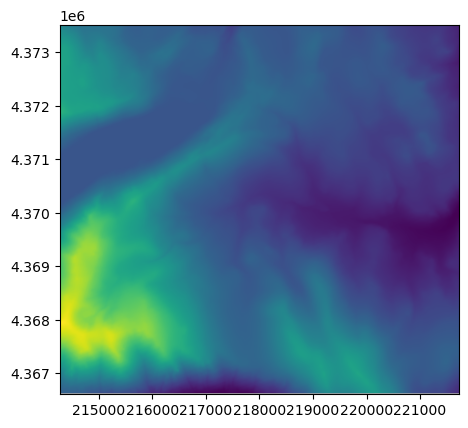

In [2]:
data_ws = Path("./data")
geospatial_ws = data_ws / "unstructured_grid_data"
dem = geospatial_ws / "dem.img"
rstr = Raster.load(dem)
rstr.plot();

Get the DEM boundaries

In [3]:
xmin, xmax, ymin, ymax = rstr.bounds
epsg = rstr.crs.to_epsg()
print(f"{xmin=}, {xmax=}")
print(f"{epsg=}")

xmin=214270.0, xmax=221720.0
epsg=26911


And begin developing an initial mesh for the model

In [4]:
# live code modelgrid creation
cellsize = 200
ncol = int(np.ceil((xmax - xmin) / cellsize))
nrow = int(np.ceil((ymax - ymin) / cellsize))
nlay = 1

delc = np.full((nrow,), cellsize)
delr = np.full((ncol,), cellsize)

Finally create a fake top, bottom, and idomain for the model for now. These will be refined in a subsequent step.

In [5]:
# live code modelgrid creation
top = np.full((nrow, ncol), 100)
botm = np.full((1, nrow, ncol), 0)
idomain = np.ones(botm.shape, dtype=int)

And now we can generate a `StructuredGrid` object that can be used for developing model inputs

In [6]:
# live code modelgrid creation
sgrid = StructuredGrid(
    delc=delc,
    delr=delr,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    top=top,
    botm=botm,
    idomain=idomain,
    xoff=xmin,
    yoff=ymin
)

We can plot our `SturcturedGrid` object over the existing raster data to check that it is correctly orientied in space

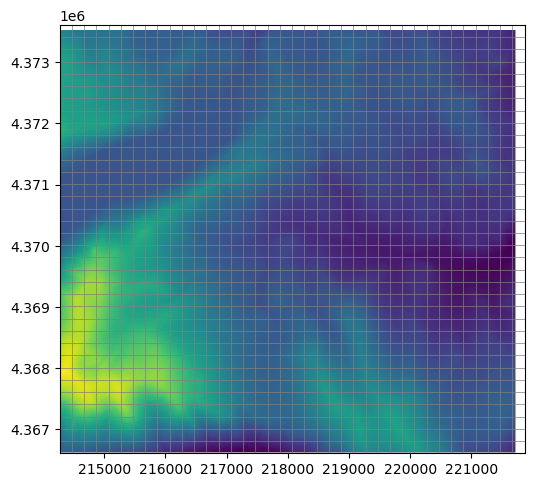

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
rstr.plot(ax=ax)
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
pmv.plot_grid(lw=0.5);

### Resampling data to finish creating our initial grid.

Once we have an initial grid, raster and vector data can be resampled or intersected with the grid to begin building a model domain. Although the focus of this notebook is to generate different types of meshes for modeling, the resampling and intersection process in this notebook can be applied many different data types and be used to generate boundary conditions within a MODFLOW model.

#### Raster resampling
We'll use FloPy's built in raster resampling method to generate values for land surface elevation (`top`) using the existing `StructuredGrid` object. For more information on raster resampling, please see this [example](https://flopy.readthedocs.io/en/latest/Notebooks/raster_intersection_example.html)

In [8]:
top = rstr.resample_to_grid(
    sgrid, rstr.bands[0], method="min", extrapolate_edges=True
)

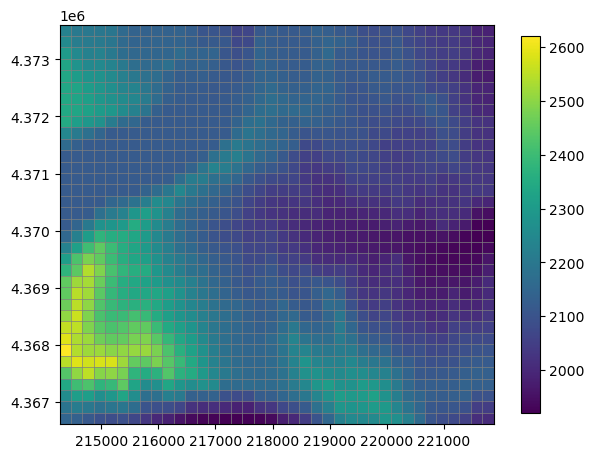

In [9]:
fig, ax = plt.subplots(figsize=(7, 7))
pmv = PlotMapView(modelgrid=sgrid)
pc = pmv.plot_array(top)
pmv.plot_grid(lw=0.5)
plt.colorbar(pc, shrink=0.7);

### Vector (shapefile) intersection review

We can also intersect lines, points, and polygons with an existing modelgrid object. In this example, we'll load up the watershed boundary and get the active and inactive areas of the grid. For more information on intersecting shapefiles with a modelgrid/model see this [example](https://flopy.readthedocs.io/en/latest/Notebooks/grid_intersection_example.html)

Our first step in this process is to get the watershed boundary. We can use the `dataretrieval` package to begin downloading information about the watershed from NWIS.

**Note**: this information has been stored in the repository as shapefiles if internet access is not available.

In [10]:
# the get_info() call accepts a decimal lat/lon bounding box
griddf = sgrid.geo_dataframe.set_crs(epsg=26911)
grid_wgs = griddf.to_crs(epsg=4326)

wxmin, wxmax, wymin, wymax = grid_wgs.total_bounds
wgs_bounds = [wxmin, wymin, wxmax, wymax]

try:
    info, metadata = nwis.get_info(bBox=[f"{i :.2f}" for i in wgs_bounds])
except (ValueError, ConnectionError, NameError):
    info = gpd.read_file(geospatial_ws / "gage_info.shp")

info.head()

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_v,coord_meth,coord_acy_,...,reliabilit,gw_file_cd,nat_aqfr_c,aqfr_cd,aqfr_type_,well_depth,hole_depth,depth_src_,project_no,geometry
0,USGS,10342900,INDEPENDENCE LK NR TRUCKEE CA,LK,392707.0,1201723.00,39.451849,-120.290759,M,F,...,None,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (216838.412 4372090.976)
1,USGS,10343000,INDEPENDENCE C NR TRUCKEE CA,ST,392724.0,1201710.00,39.456572,-120.287148,M,F,...,None,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (217168.338 4372603.864)
2,USGS,10343500,SAGEHEN C NR TRUCKEE CA,ST,392554.0,1201413.00,39.431572,-120.237979,M,F,...,None,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (221299.997 4369675.311)
3,USGS,392501120182800,SAGEHEN CR NR CARPENTER RIDGE CA,ST,392501.0,1201828.00,39.416849,-120.308814,M,S,...,None,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (215141.782 4368262.355)
4,USGS,392553120142301,NADP NTN CA50 A SAGEHEN CREEK NR TRUCKEE CA,AT,392553.4,1201422.92,39.431500,-120.239700,M,M,...,U,Y,NaN,NaN,NaN,NaN,NaN,NaN,NADP,POINT (221151.573 4369672.591)


Reproject the gage data into UTM Zone 11 N

In [11]:
info = info.to_crs(epsg=epsg)

And plot the gage data on the raster

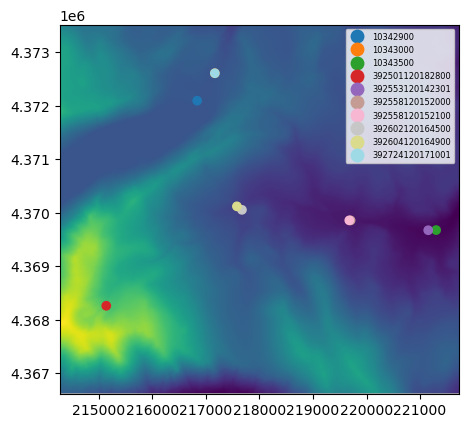

In [12]:
fig, ax = plt.subplots()

rstr.plot(ax=ax)
info.plot(
    column="site_no",
    ax=ax,
    cmap="tab20",
    legend=True,
    legend_kwds={"fontsize": 6},
);

Grab the site record for gage number 10343500

In [13]:
sitedf = info.loc[info.site_no == "10343500"]
sitedf

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_v,coord_meth,coord_acy_,...,reliabilit,gw_file_cd,nat_aqfr_c,aqfr_cd,aqfr_type_,well_depth,hole_depth,depth_src_,project_no,geometry
2,USGS,10343500,SAGEHEN C NR TRUCKEE CA,ST,392554.0,1201413.0,39.431572,-120.237979,M,F,...,None,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,None,POINT (221299.997 4369675.311)


Get the upstream basin from nldi using the NWIS stream gage station code

In [14]:
try:
    basindf = nldi.get_basin(
        feature_source="nwissite",
        feature_id=f"USGS-{sitedf.site_no.values[0]}",
    )
    basindf = basindf.to_crs(epsg=epsg)
except (ValueError, ConnectionError, NameError):
    basindf = gpd.read_file(geospatial_ws / "basin_boundary.shp")

Plot up the basin boundary with the existing raster

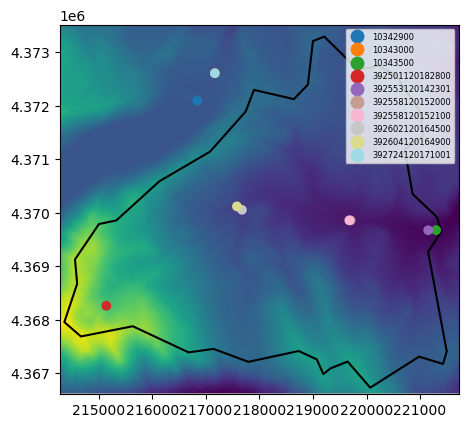

In [15]:
fig, ax = plt.subplots()
rstr.plot(ax=ax)
basindf.plot(ax=ax, facecolor="None", edgecolor="k", lw=1.5)
info.plot(
    column="site_no",
    ax=ax,
    cmap="tab20",
    legend=True,
    legend_kwds={"fontsize": 6},
);

Doing the intersection

In [16]:
ix = GridIntersect(sgrid, method="vertex")
result = ix.intersect(basindf.geometry.values[0], contains_centroid=True)
rowcol = result["cellids"]
rowcol

array([(np.int64(2), np.int64(24)), (np.int64(2), np.int64(25)),
       (np.int64(3), np.int64(23)), (np.int64(3), np.int64(24)),
       (np.int64(3), np.int64(25)), (np.int64(3), np.int64(26)),
       (np.int64(4), np.int64(23)), (np.int64(4), np.int64(24)),
       (np.int64(4), np.int64(25)), (np.int64(4), np.int64(26)),
       (np.int64(4), np.int64(27)), (np.int64(4), np.int64(29)),
       (np.int64(5), np.int64(23)), (np.int64(5), np.int64(24)),
       (np.int64(5), np.int64(25)), (np.int64(5), np.int64(26)),
       (np.int64(5), np.int64(27)), (np.int64(5), np.int64(28)),
       (np.int64(5), np.int64(29)), (np.int64(5), np.int64(30)),
       (np.int64(5), np.int64(31)), (np.int64(6), np.int64(23)),
       (np.int64(6), np.int64(24)), (np.int64(6), np.int64(25)),
       (np.int64(6), np.int64(26)), (np.int64(6), np.int64(27)),
       (np.int64(6), np.int64(28)), (np.int64(6), np.int64(29)),
       (np.int64(6), np.int64(30)), (np.int64(6), np.int64(31)),
       (np.int64(7), np.i

In [17]:
row, col = list(zip(*rowcol))

Building idomain from the intersection

In [18]:
idomain = np.zeros((nlay, nrow, ncol), dtype=int)
idomain[:, row, col] = 1

#### Putting it all together into a completed `StructuredGrid`

In [19]:
sgrid = StructuredGrid(
    delc=sgrid.delc,
    delr=sgrid.delr,
    top=top,
    botm=sgrid.botm,
    idomain=idomain,
    nlay=sgrid.nlay,
    nrow=sgrid.nrow,
    ncol=sgrid.ncol,
    xoff=sgrid.xoffset,
    yoff=sgrid.yoffset,
    crs=sgrid.crs,
)
sgrid

xll:214270.0; yll:4366610.0; rotation:0.0; units:undefined; lenuni:0

Plotting the completed grid with gage locations and the watershed boundary

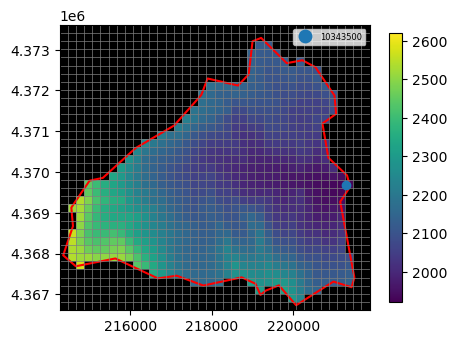

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))
pmv = PlotMapView(modelgrid=sgrid)
pc = pmv.plot_array(sgrid.top)
ib = pmv.plot_inactive()
pmv.plot_grid(lw=0.5)
plt.colorbar(pc, shrink=0.7)

basindf.plot(ax=ax, facecolor="None", edgecolor="r", lw=1.5)
sitedf.plot(
    column="site_no",
    ax=ax,
    cmap="tab20",
    legend=True,
    legend_kwds={"fontsize": 6},
    zorder=6
);

Because this is a watershed, we can also overlay a shapefile of the streams and get the stream cells using `GridIntersect`

NHD-Plus stream lines can be downloaded using streamgage information with the `dataretrieval` package

In [21]:
try:
    nhddf = nldi.get_flowlines(
        navigation_mode="UT",
        distance=999,
        feature_source="nwissite",
        feature_id=f"USGS-{sitedf.site_no.values[0]}",
    )
    nhddf = nhddf.to_crs(epsg=epsg)
except (ValueError, ConnectionError, NameError):
    nhddf = gpd.read_file(geospatial_ws / "nhd_streams.shp")

nhddf.head()

,geometry,nhdplus_comid
0,"LINESTRING (221038.59 4369598.73, 221076.943 4...",8933522
1,"LINESTRING (220451.353 4367186.202, 220542.627...",8933608
2,"LINESTRING (220541.209 4369697.393, 220691.816...",8933524
3,"LINESTRING (219823.023 4371753.116, 219905.68 ...",8934342
4,"LINESTRING (220240.836 4369758.678, 220245.466...",8933520


Intersect stream lines with the existing modelgrid

In [22]:
rowcols = []
ix = GridIntersect(sgrid, method="vertex")
for geom in nhddf.geometry.values:
    rcs = ix.intersects(geom)["cellids"]
    rowcols.extend(list(rcs))

In [23]:
row, col = list(zip(*rowcols))
strms = np.zeros((nrow, ncol))
strms[row, col] = 1
strms

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(35, 38))

Plot the intersection results

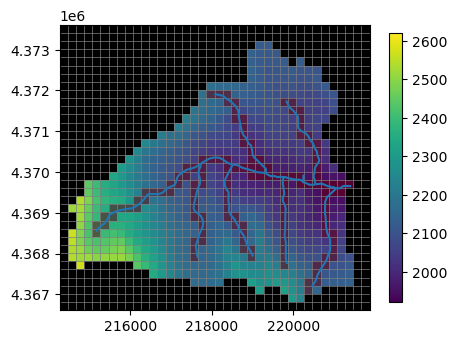

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
pc = pmv.plot_array(sgrid.top, cmap="viridis")
pmv.plot_array(strms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.5)
plt.colorbar(pc, shrink=0.7)
nhddf.plot(ax=ax);

Information from the grid we've created here can now be used for generating more complex meshes.

## Irregular structured Grid (DIS)

In this example, an irregular structured grid is created to demonstrate how to add local refinement to an area of the model using a structured (rectilinear) grid. 

In [25]:
lx = xmax - xmin
ly = ymax - ymin
cellsize = 200
rcellsize = 100

smooth = np.linspace(100, 200, 10).tolist()
delr = 9 * [cellsize] + smooth[::-1] + 8 * [rcellsize] + smooth + 9 * [cellsize] 
delc = 8 * [cellsize] + smooth[::-1] + 7 * [rcellsize] + smooth + 8 * [cellsize]
nlay = 1
nrow = len(delc)
ncol = len(delr)

# create some fake data for the moment
top = np.ones((nrow, ncol))
botm = np.zeros((nlay, nrow, ncol))
idomain = np.ones(botm.shape, dtype=int)

In [26]:
rfgrid = StructuredGrid(
    delc=np.array(delc),
    delr=np.array(delr),
    nlay=nlay,
    top=top,
    botm=botm,
    idomain=idomain,
    xoff=xmin,
    yoff=ymin
)
print(nlay, nrow, ncol)
print(rfgrid.nrow, rfgrid.ncol)

1 43 46
43 46


Intersect the basin boundary with the grid to set active and inactive cells (idomain)

In [27]:
ix = GridIntersect(rfgrid, method="vertex")
result = ix.intersect(basindf.geometry.values[0], contains_centroid=True)
rowcol = result["cellids"]

row, col = list(zip(*rowcol))
idomain = np.zeros((nlay, nrow, ncol), dtype=int)
idomain[:, row, col] = 1

# tricky way so we don't have to recreate the grid
rfgrid._idomain = idomain

Resample the top elevation

In [28]:
top = rstr.resample_to_grid(
    rfgrid, rstr.bands[0], method="min", extrapolate_edges=True
)

# tricky way so we don't have to recreate the grid
rfgrid._top = top

Now we can plot the grid

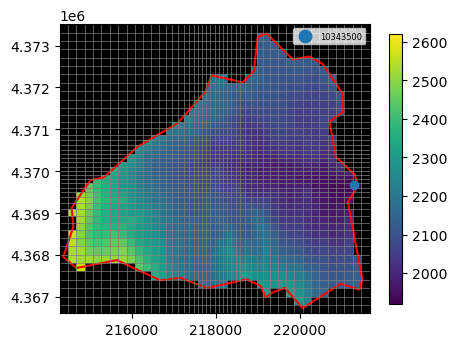

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
pmv = PlotMapView(modelgrid=rfgrid)
pc = pmv.plot_array(rfgrid.top, cmap="viridis")
ib = pmv.plot_inactive()
pmv.plot_grid(lw=0.5)
plt.colorbar(pc, shrink=0.7)

basindf.plot(ax=ax, facecolor="None", edgecolor="r", lw=1.5)
sitedf.plot(
    column="site_no",
    ax=ax,
    cmap="tab20",
    legend=True,
    legend_kwds={"fontsize": 6},
    zorder=6
);

## Local Grid Refinement (LGR) mesh

A Local Grid Refinement (LGR) mesh can be created in an area of interest to get finer discretization than the existing/surrounding mesh. FloPy's `Lgr` utility, creates the refined mesh as a seperate modelgrid, and calculates the exchanges between the multi-model simulation mesh that results from refinement. 

The `Lgr` utility has a number of input parameters:
   - `nlayp`: the number of parent model layers
   - `nrowp`: the number of parent model rows
   - `ncolp`: the number of parent model columns
   - `delrp`: the parent model delr array
   - `delcp`: the parent model delc array
   - `topp`: the parent model top array
   - `botmp`: the parent model botm array
   - `idomainp`: an idomain array that is used to create the child grid. Values of 1 indicate parent model cells, values of 0 indicate child model cells. The child model must be a rectangular region that is continuous.
   - `ncpp`: number of child cells along the face of a parent cell
   - `ncppl`: number of child cells per parent layer
   - `xllp`: (optional) x location of parent grid lower left corner
   - `yllp`: (optional) y-location of parent grid lower left corner

**Load up the refinement area polygon**

In [30]:
lgr_gdf = gpd.read_file(geospatial_ws / "lgr_bound.shp")

Plot it to see if it lines up properly with our model

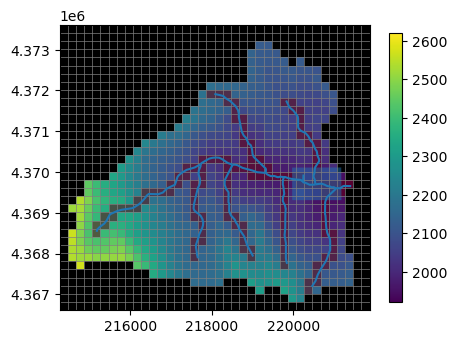

In [31]:
fig, ax = plt.subplots(figsize=(5, 5))
pmv = PlotMapView(modelgrid=sgrid, ax=ax)
pc = pmv.plot_array(sgrid.top, cmap="viridis")
pmv.plot_array(strms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.5)
nhddf.plot(ax=ax)
lgr_gdf.plot(ax=ax, alpha=0.5)
plt.colorbar(pc, shrink=0.7);

Creating the parent/child idomainp array for `Lgr` using `GridIntersect`

In [32]:
lgr_gdf

,Id,geometry
0,0,"POLYGON ((221180.716 4369310.065, 219973.134 4..."


## Activity: Create the `idomainp` (parent, child) array from the polygon provided by the lgr geodataframe

`idomainp` should be the same shape as the existing modelgrid's `idomain` array. The child model extent should be represented with the value 0 and the parent 1.

*Hint*: `GridIntersect()` can be used to find the cellids where the lgr polygon intersects with the existing modelgrid

In [33]:
# live code this/give it as an activity
idomainp = np.ones(sgrid.idomain.shape, dtype=int)

gix = GridIntersect(sgrid, method="vertex")
result = gix.intersect(lgr_gdf.geometry.values[0])
cid = result["cellids"]

crow, ccol = list(zip(*cid))
idomainp[:, crow, ccol] = 0

Creating the `Lgr` object/child grid

In [34]:
lgr = Lgr(
    nlayp=sgrid.nlay,
    nrowp=sgrid.nrow,
    ncolp=sgrid.ncol,
    delrp=sgrid.delr,
    delcp=sgrid.delc,
    topp=sgrid.top,
    botmp=sgrid.botm,
    idomainp=idomainp,
    ncpp=4,
    xllp=sgrid.xoffset,
    yllp=sgrid.yoffset,
)

Get a `StructuredGrid` of the child model

In [35]:
childgrid = lgr.child.modelgrid
childgrid

xll:219870.0; yll:4369210.0; rotation:0.0; units:undefined; lenuni:0

Resample top elevations to the child grid

In [36]:
childtop = rstr.resample_to_grid(childgrid, band=rstr.bands[0], method="min")
print(childtop.shape)
print(childgrid.shape)

(20, 28)
(1, 20, 28)


Reset the top elevations in the `childgrid` object

In [37]:
childgrid._top = childtop

Intersect streams with the Child mesh to define stream cells

In [38]:
ix = GridIntersect(childgrid, method="vertex")
cstrmcells = []
for geom in nhddf.geometry.values:
    rcs = ix.intersects(geom)["cellids"]
    if len(rowcol) > 0:
        cstrmcells.extend(list(rcs))

cstrms = np.zeros((childgrid.nrow, childgrid.ncol), dtype=int)
row, col = list(zip(*cstrmcells))
cstrms[row, col] = 1

And now we can visualize the new LGR mesh

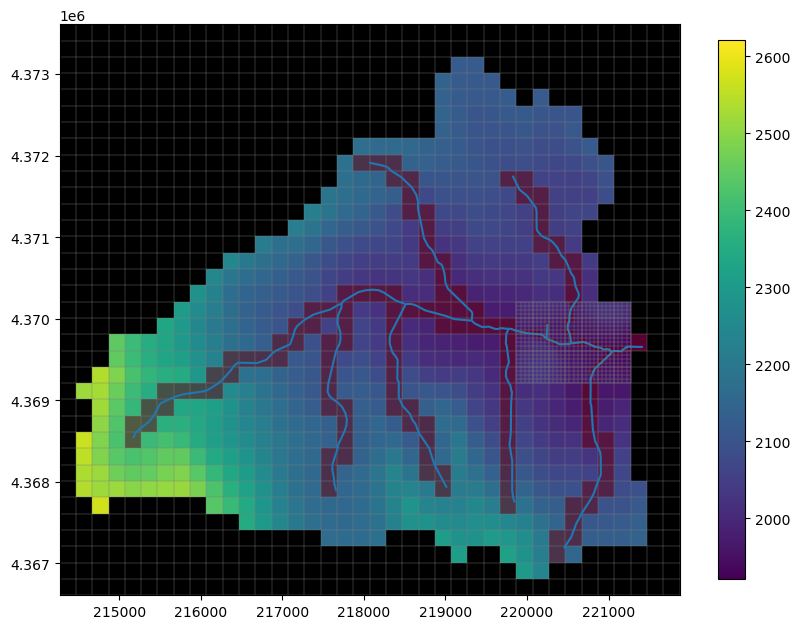

In [39]:
fig, ax = plt.subplots(figsize=(10, 10))
vmin, vmax = np.min(sgrid.top), np.max(sgrid.top)

# plot the parent
pmvp = PlotMapView(modelgrid=sgrid, ax=ax)
ptop = sgrid.top.copy()
ptop[crow, ccol] = np.nan
strms[crow, ccol] = np.nan
pc = pmvp.plot_array(ptop, cmap="viridis", vmin=vmin, vmax=vmax)
pmvp.plot_array(strms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmvp.plot_inactive()
pmvp.plot_grid(lw=0.3)
nhddf.plot(ax=ax)

# plot the child
pmvc = PlotMapView(modelgrid=childgrid, ax=ax, extent=sgrid.extent)
pmvc.plot_array(childtop, cmap="viridis", vmin=vmin, vmax=vmax)
pmvc.plot_array(cstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmvc.plot_grid(lw=0.3)
plt.colorbar(pc, shrink=0.7);

## Quadtree Mesh

A quadtree mesh is an unstructured refinement to a rectilinear modelgrid. In a quadtree mesh each node is split into 4 child nodes per level of refinement. The figure below is from [Lien and others, 2019](https://pubs.usgs.gov/of/2014/1109/pdf/ofr2014-1109.pdf) and shows multiple levels of recursive refinement.

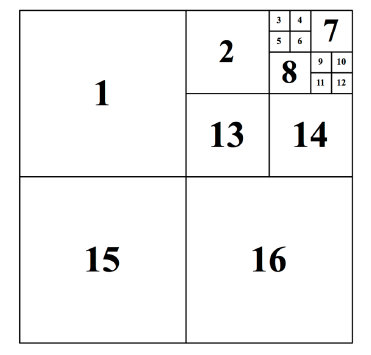

For this example, we will be using GRIDGEN and the FloPy utility `Gridgen` to create quadtree refinement around the streams in our example.

In [40]:
gridgen_dir = data_ws / "sagehen_gridgen"
gridgen_dir.mkdir(exist_ok=True)

The `Gridgen` class a number of input parameters and further documentation/examples of the class can be found [here](https://flopy.readthedocs.io/en/latest/Notebooks/gridgen_example.html). For our example, we will be refining the area around the stream channels.

In [41]:
g = Gridgen(sgrid, model_ws=gridgen_dir)
for geom in nhddf.geometry.values:
    xy = list(zip(*geom.coords.xy))
    g.add_refinement_features([xy,], "line", 2, [0,])

In [42]:
g.build()

After gridgen builds the mesh, it can be used to create a `VertexGrid` (or DISV) that represents the basin

In [43]:
gridprops = g.get_gridprops_disv()
gridprops.pop("nvert")

quadgrid = VertexGrid(**gridprops)
quadgrid.extent

(np.float64(214270.0),
 np.float64(221870.0),
 np.float64(4366610.0),
 np.float64(4373610.0))

Resample top elevations to the quadtree mesh and intersect the basin boundary and stream vectors

In [44]:
# create the top array
top = rstr.resample_to_grid(quadgrid, band=rstr.bands[0], method="min")
quadgrid._top = top

In [45]:
# create the idomain array
idomain = np.zeros(quadgrid.shape, dtype=int)
ix = GridIntersect(quadgrid, method="vertex")
nodes = ix.intersect(basindf.geometry.values[0], contains_centroid=True)["cellids"]

idomain[:, list(nodes)] = 1
quadgrid._idomain = idomain

In [46]:
# create an array of stream cells
qstr = []
ix = GridIntersect(quadgrid, method="vertex")
for geom in nhddf.geometry.values:
    nodes = ix.intersects(geom)["cellids"]
    qstr.extend(list(nodes))

In [47]:
qstrms = np.zeros((quadgrid.ncpl,), dtype=int)
qstrms[qstr] = 1

Plot the quadtree mesh with top elevations and streams

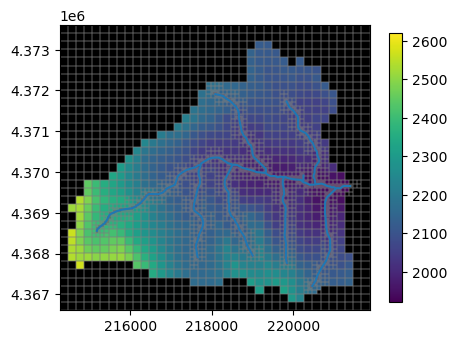

In [48]:
fig, ax = plt.subplots(figsize=(5, 5))

pmv = PlotMapView(modelgrid=quadgrid)
pc = pmv.plot_array(quadgrid.top)
pmv.plot_array(qstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.3)
nhddf.plot(ax=ax)
plt.colorbar(pc, shrink=0.7);

## Triangular Mesh

An unstructured/vertex based triangular mesh can be generated using the code "triangle"([Shewchuk, 2002](https://www.sciencedirect.com/science/article/pii/S0925772101000475)). And the FloPy utility, `Triangle` that creates inputs for and translates the outputs from "triangle". 

For this example, we will be using triangle to generate a mesh and add refinement around the streams.

In [49]:
tri_dir = data_ws / "sagehen_tri"
tri_dir.mkdir(exist_ok=True)

For this example, we will use the watershed boundary we downloaded from NLDI and create a dissovled polygon of stream segments to generate our triangulation regions.

In [50]:
basindf.head()

,geometry
0,"POLYGON ((219324.508 4367092.598, 219194.216 4..."


We will also dissolve and buffer the stream network into a single polygon that defines our area of refinement

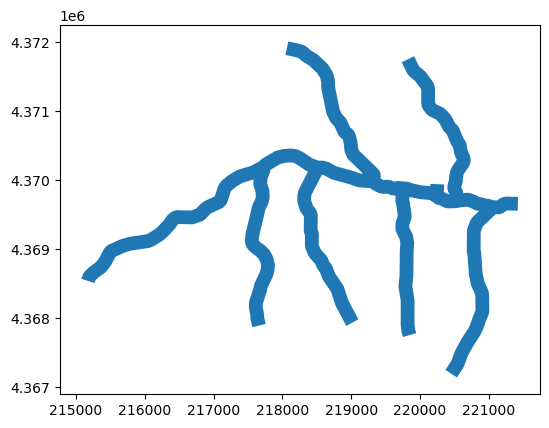

In [51]:
bufgdf = nhddf.dissolve()
bufgdf["geometry"] = bufgdf.geometry.buffer(100, cap_style=2, join_style=3)
bufgdf.plot();

These two polygons can now be used to generate a triangular mesh with the `Triangle` utility. The `Triangle` class has a number of input parameters. For more detail on the inputs and additional examples please see this [notebook](https://flopy.readthedocs.io/en/latest/Notebooks/dis_voronoi_example.html)

In [52]:
# define point locations within the watershed and the stream for adding regions
wsloc = (220000, 4368000)
stloc = (219250, 4370000)

In [53]:
tri = Triangle(angle=30, model_ws=tri_dir)

# define the model/mesh boundary
tri.add_polygon(basindf.geometry.values[0])
tri.add_region(wsloc, 0, maximum_area=100 * 300)

# define the stream refinement area
tri.add_polygon(bufgdf.geometry.values[0])
tri.add_region(stloc, 1, maximum_area=40 * 40)

In [54]:
tri.build()

Visualize the triangular mesh

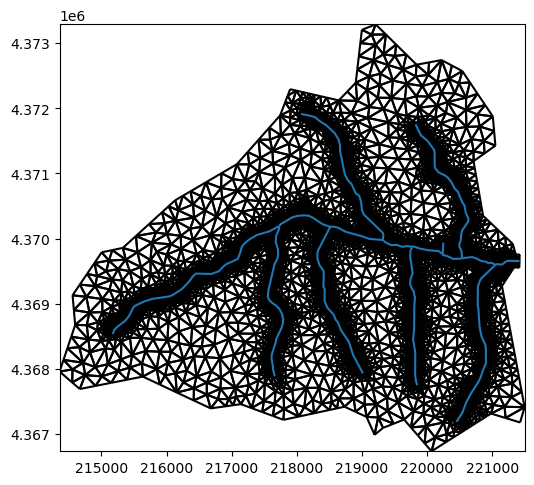

In [55]:
fig, ax = plt.subplots(figsize=(6, 6))
tri.plot(ax=ax)
nhddf.plot(ax=ax);

Create a `VertexGrid` from the triangular mesh and resample the land surface elevations

In [56]:
cell2d = tri.get_cell2d()
vertices = tri.get_vertices()
ncpl = len(cell2d)
nlay = 1
idomain = np.ones((nlay, ncpl), dtype=int)

# set fake values for top and botm for now)
top = np.ones((ncpl,))
botm = np.zeros((nlay, ncpl))

In [57]:
trigrid = VertexGrid(
    vertices=vertices,
    cell2d=cell2d,
    ncpl=ncpl,
    nlay=nlay,
    idomain=idomain,
    top=top,
    botm=botm,
    crs="EPSG:26911",
)
trigrid.extent

(np.float64(214358.62207605224),
 np.float64(221497.55795538268),
 np.float64(4366733.474127463),
 np.float64(4373287.261484375))

In [58]:
top = rstr.resample_to_grid(
    trigrid, band=rstr.bands[0], method="min", extrapolate_edges=True
)
trigrid._top = top

And perform intersection to identify stream cells

In [59]:
tristr = []
ix = GridIntersect(trigrid, method="vertex")
for geom in nhddf.geometry.values:
    nodes = ix.intersects(geom)["cellids"]
    tristr.extend(list(nodes))

tristrms = np.zeros((trigrid.ncpl,), dtype=int)
tristrms[tristr] = 1

Now to plot up the triangular grid

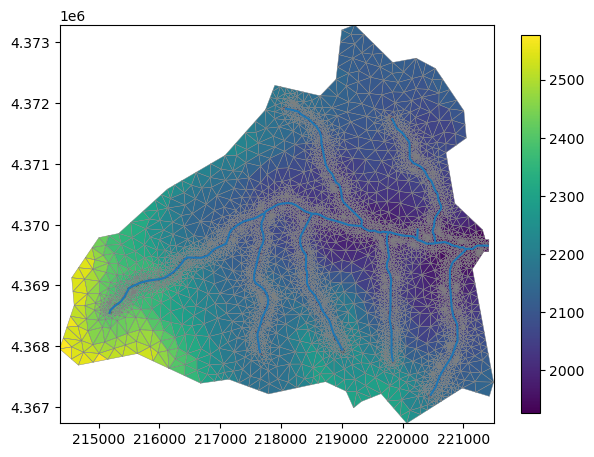

In [60]:
fig, ax = plt.subplots(figsize=(7, 7))

pmv = PlotMapView(modelgrid=trigrid)
pc = pmv.plot_array(trigrid.top)
pmv.plot_array(tristrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.3)
nhddf.plot(ax=ax)
plt.colorbar(pc, shrink=0.7);

## Voronoi Mesh

A voronoi mesh can be generated from the circumcirle centroids of each triangular node in a Delaunay triangulation. The centroid of each circumcirle produces a vertex for the voronoi mesh and these vertices are connected via adjacency relationships of the triangulation. 

FloPy has a built in utility `VoronoiGrid` that produces voronoi meshes from Delaunay triangulations. For more information and additional examples on `VoronoiGrid`'s usage, see this [notebook](https://flopy.readthedocs.io/en/latest/Notebooks/dis_voronoi_example.html)

To generate a voronoi mesh, we just need to pass our triangluation object (`tri`) to the `VoronoiGrid` utility

In [61]:
vor = VoronoiGrid(tri)

Build a `VertexGrid`

In [62]:
gridprops = vor.get_gridprops_vertexgrid()
nlay = 1
idomain = np.ones(gridprops["ncpl"], dtype=int)
top = idomain.copy().astype(float)
botm = np.zeros((nlay, gridprops["ncpl"]))

In [63]:
vorgrid = VertexGrid(
    nlay=nlay, idomain=idomain, top=top, botm=botm, **gridprops
)

Resample the land surface elevation from the DEM to the voronoi grid

In [64]:
top = rstr.resample_to_grid(
    vorgrid, band=rstr.bands[0], method="min", extrapolate_edges=True
)
vorgrid._top = top

Identify stream cells with `GridIntersect`

In [65]:
vorst = []
ix = GridIntersect(vorgrid, method="vertex")
for geom in nhddf.geometry.values:
    nodes = ix.intersects(geom)["cellids"]
    vorst.extend(list(nodes))

vorstrms = np.zeros((vorgrid.ncpl,), dtype=int)
vorstrms[vorst] = 1

Finally plot the voronoi mesh with the DEM data and stream locations

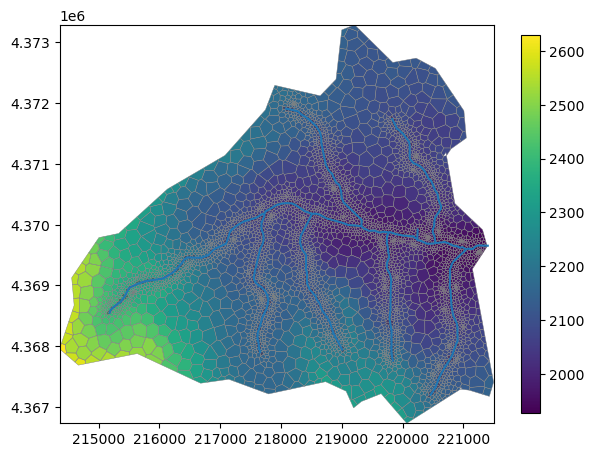

In [66]:
fig, ax = plt.subplots(figsize=(7, 7))

pmv = PlotMapView(modelgrid=vorgrid)
pc = pmv.plot_array(vorgrid.top)
pmv.plot_array(vorstrms, masked_values=[0], alpha=0.3, cmap="Reds_r")
pmv.plot_inactive()
pmv.plot_grid(lw=0.3)
nhddf.plot(ax=ax)
plt.colorbar(pc, shrink=0.7);

### plot the meshes we produced side by side for comparison!

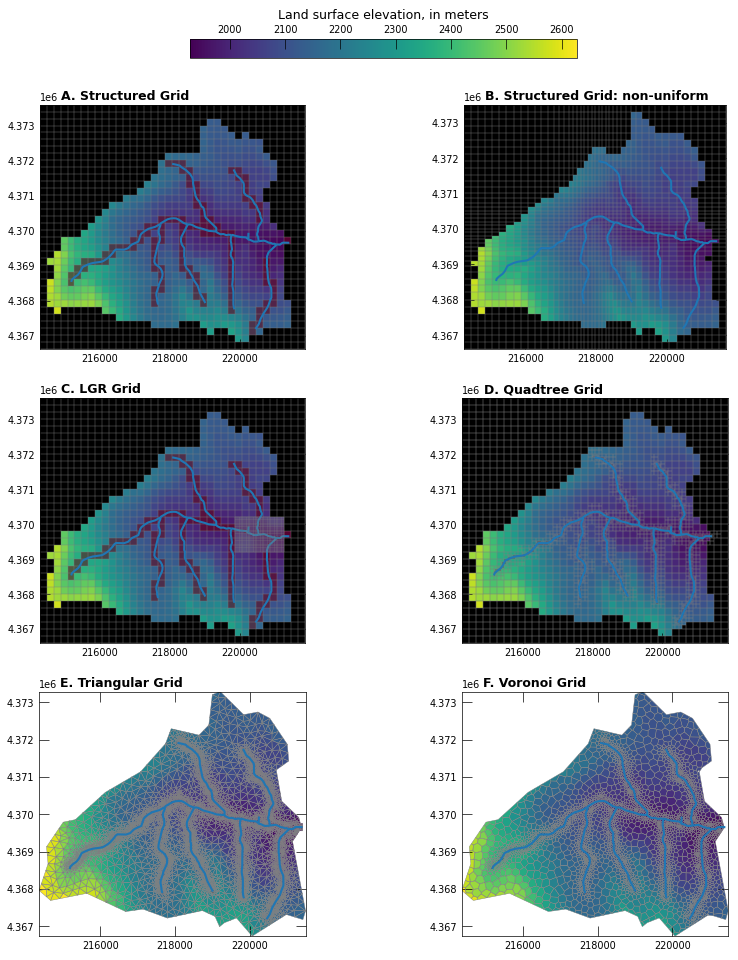

In [67]:
from flopy.plot import styles
from matplotlib.gridspec import GridSpec

with styles.USGSMap():
    fig, axm = plt.subplots(nrows=3, ncols=2, figsize=(10,12))
    axs = axm.ravel()
    
    # structured grid
    pmv = PlotMapView(modelgrid=sgrid, ax=axs[0])
    pmv.plot_array(sgrid.top, cmap="viridis")
    pmv.plot_array(strms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmv.plot_inactive()
    pmv.plot_grid(lw=0.3)
    nhddf.plot(ax=axs[0])
    styles.heading(axs[0], "A. ", heading="Structured Grid", x=0.08)

    # non-uniform DIS
    pmv = PlotMapView(modelgrid=rfgrid, ax=axs[1])
    pmv.plot_array(rfgrid.top, cmap="viridis")
    pmv.plot_inactive()
    pmv.plot_grid(lw=0.3)
    nhddf.plot(ax=axs[1])
    styles.heading(axs[1], "B.", heading="Structured Grid: non-uniform", x=0.08)

    # LGR grid
    pmvp = PlotMapView(modelgrid=sgrid, ax=axs[2])
    ptop = sgrid.top.copy()
    ptop[crow, ccol] = np.nan
    strms[crow, ccol] = np.nan
    pc = pmvp.plot_array(ptop, cmap="viridis", vmin=vmin, vmax=vmax)
    pmvp.plot_array(strms, masked_values=[0], alpha=0.3, cmap="Reds_r")
    pmvp.plot_inactive()
    pmvp.plot_grid(lw=0.3)
    nhddf.plot(ax=axs[2])

    pmvc = PlotMapView(modelgrid=childgrid, ax=axs[2])
    pmvc.plot_array(childtop, cmap="viridis", vmin=vmin, vmax=vmax)
    pmvc.plot_array(cstrms, masked_values=[0], alpha=0.3, cmap="Reds_r")
    pmvc.plot_grid(lw=0.3)
    styles.heading(axs[2], "C. ", heading="LGR Grid", x=0.08)

    # Quadtree grid
    pmv = PlotMapView(modelgrid=quadgrid, ax=axs[3])
    pc = pmv.plot_array(quadgrid.top)
    pmv.plot_array(qstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmv.plot_inactive()
    pmv.plot_grid(lw=0.2)
    nhddf.plot(ax=axs[3])
    styles.heading(axs[3], "D. ", heading="Quadtree Grid", x=0.08)

    # Triangular grid
    pmv = PlotMapView(modelgrid=trigrid, ax=axs[4])
    pc = pmv.plot_array(trigrid.top)
    pmv.plot_array(tristrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmv.plot_inactive()
    pmv.plot_grid(lw=0.3)
    nhddf.plot(ax=axs[4])
    styles.heading(axs[4], "E. ", heading="Triangular Grid", x=0.08)

    # Voronoi grid
    pmv = PlotMapView(modelgrid=vorgrid, ax=axs[5])
    pc = pmv.plot_array(vorgrid.top)
    pmv.plot_array(vorstrms, masked_values=[0,], alpha=0.3, cmap="Reds_r")
    pmv.plot_inactive()
    pmv.plot_grid(lw=0.3)
    nhddf.plot(ax=axs[5])
    styles.heading(axs[5], "F. ", heading="Voronoi Grid", x=0.08)

    # colorbar

    
    # ax5.spines[["left", "right", "top", "bottom"]].set_visible(False)
    fig.colorbar(
        pc,
        ax=axm,
        location="top",
        label="Land surface elevation, in meters",
        shrink=0.5,
        fraction=.05
    )


### More information 
For more inforation and and examples on how to use the utilities presented in this notebook please see:

#### Examples
   - [FloPy Examples Gallery](https://flopy.readthedocs.io/en/latest/examples.html)

#### API reference
   - [FloPy utils API reference](https://flopy.readthedocs.io/en/latest/code.html#flopy-utilities)
   - [FloPy lgrutil API reference](https://flopy.readthedocs.io/en/latest/source/flopy.utils.lgrutil.html)
   - [FloPy gridgen API reference](https://flopy.readthedocs.io/en/latest/source/flopy.utils.gridgen.html)
   - [FloPy triangle API reference](https://flopy.readthedocs.io/en/latest/source/flopy.utils.triangle.html)
   - [FloPy voronoi API reference](https://flopy.readthedocs.io/en/latest/source/flopy.utils.voronoi.html)

## Activity (If time permits); Build a Voronoi mesh/Vertex Grid:

Define a voronoi grid for the basin upstream of the Black Earth Creek streamgauge near Cross Plains, WI. The upstream basin information is supplied by NLDI and has been saved to the class repo in case of internet connectivity or NLDI service issues.

Some of the previous code can be re-used to create a voronoi mesh and subsequent `VertexGrid` representation of the basin. See the Triangular and Voronoi grid sections of the notebook.

**Optional**, use the Upstream Main segment of Black Earth Creek to refine the voronoi mesh around the stream location. Refinement control points have been pre-defined below.

In [68]:
epsg = 5070  # NAD83 CONUS Albers
# try:
    # todo: update this for black earth creek near cross plains WI site-no 05406479
be_cr_nr_cp = "05406479"
basindf = nldi.get_basin(
    feature_source="nwissite", feature_id=f"USGS-{be_cr_nr_cp}"
)
basindf = basindf.to_crs(epsg=epsg)
basindf.to_file(geospatial_ws / "black_earth_basin.shp")
# except (ValueError, ConnectionError, NameError):
#     basindf = gpd.read_file(geospatial_ws / "black_earth_basin.shp")

In [69]:
try:
    nhddf = nldi.get_flowlines(
        navigation_mode="UM",
        distance=9999,
        feature_source="nwissite",
        feature_id=f"USGS-{be_cr_nr_cp}",
    )
    nhddf = nhddf.to_crs(epsg=epsg)
    nhddf.to_file(geospatial_ws / "black_earth_creek_main.shp")
except (ValueError, ConnectionError, NameError):
    nhddf = gpd.read_file(geospatial_ws / "black_earth_creek_main.shp")

C:\Users\jlarsen\AppData\Local\Temp\1\ipykernel_33328\1781832700.py:9: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nhddf.to_file(geospatial_ws / "black_earth_creek_main.shp")


Visualize the example "study area"

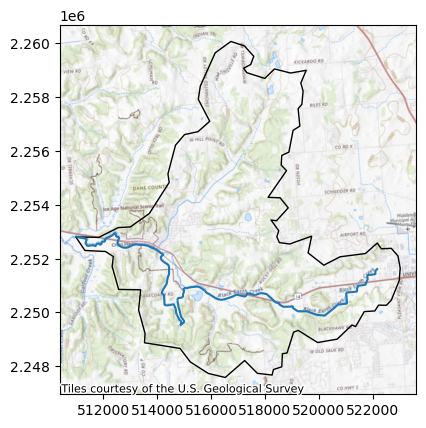

In [70]:
fig, ax = plt.subplots()

basindf.plot(ax=ax, facecolor="None", edgecolor="k")
nhddf.plot(ax=ax)
ctx.add_basemap(
    ax=ax,
    crs=basindf.crs,
    source=ctx.providers.USGS.USTopo
)

Grid refinement control points are defined here for the optional part of this exercise

In [71]:
wsloc = basindf.centroid.values[0]
stloc = list(zip(*nhddf.geometry.values[10].xy))[0]